### Imports

In [23]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect
import re
from collections import Counter
from langdetect import detect, DetectorFactory
import numpy as np

In [24]:
import sys, os
sys.path.append(os.path.abspath('../../src'))

from helper_functions.path_resolver import DynamicPathResolver

### Functions

In [25]:
def read_dataset(file_path):
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded: {file_path}")
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

In [26]:
def show_dataset_info(df, file_path):
    dataset_name = os.path.basename(file_path)
    shape = df.shape
    class_distribution = df['label'].value_counts()

    print("\nDataset Information:")
    print("---------------------")
    print(f"Dataset Name   : {dataset_name}")
    print(f"Shape          : {shape[0]} rows, {shape[1]} columns")
    print(f"Columns        : {', '.join(df.columns)}")
    print("\nClass Distribution:")
    print("--------------------")
    print(class_distribution)

    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x='label', data=df)
    ax.bar_label(ax.containers[0])
    plt.title(f"Class Distribution in {dataset_name}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

In [27]:
def show_nans(df):
    missing_data = df.isnull().sum().to_frame('Missing Values')
    print("\nMissing Values:")
    print("----------------")
    display(missing_data)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values Heatmap")
    plt.show()

In [28]:
def show_text_length_boxplots(df, ignore_nans=False):
    if ignore_nans:
        initial_row_count = len(df)
        df = df[df['subject'].notna() & df['body'].notna()]
        df = df[df['subject'].str.strip() != '']
        df = df[df['body'].str.strip() != '']
        final_row_count = len(df)
        
        print(f"Row count ignoring NaNs: {final_row_count}/{initial_row_count} ({final_row_count/initial_row_count*100:.2f}%)")
    
    df['subject_length'] = df['subject'].apply(lambda x: len(str(x).split()))
    df['body_length'] = df['body'].apply(lambda x: len(str(x).split()))
    
    subject_lengths = df['subject_length']
    body_lengths = df['body_length']
    
    print("\nText Lengths (Subject & Body):")
    print("-------------------------------")
    print(f"Max subject length: {subject_lengths.max()}")
    print(f"Min subject length: {subject_lengths.min()}")
    print(f"Avg subject length: {subject_lengths.mean():.2f}")
    print(f"Max body length: {body_lengths.max()}")
    print(f"Min body length: {body_lengths.min()}")
    print(f"Avg body length: {body_lengths.mean():.2f}")

    # Boxplts
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=subject_lengths)
    plt.title("Subject Length Distribution")
    plt.xlabel("Subject Length")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=body_lengths)
    plt.title("Body Length Distribution")
    plt.xlabel("Body Length")
    plt.show()

In [29]:
def show_text_length_bins(df):
    bins = [0, 50, 100, 200, 300, 400, 512, 1024, 2048]  
    bin_labels = ['0-50', '51-100', '101-200', '201-300', '301-400', '401-512', '513-1024', '>1024']

    df['body_length'] = df['body'].apply(lambda x: len(str(x).split()))  
    df['body_length_range'] = pd.cut(df['body_length'], bins=bins, labels=bin_labels, right=False)

    plt.figure(figsize=(10, 6))
    body_length_distribution = df['body_length_range'].value_counts().sort_index()

    sns.barplot(x=body_length_distribution.index, y=body_length_distribution.values, hue=body_length_distribution.index, palette='RdYlBu', dodge=False, legend=False)
    
    plt.title("Body Text Length Ranges")
    plt.xlabel("Length Range")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()


In [30]:
def show_most_common_sender_recipient(df):
    if 'sender' not in df.columns or 'receiver' not in df.columns:
        print("Columns 'sender' or 'receiver' are missing in the dataframe.")
        return 
    
    most_common_sender = df['sender'].mode()[0]
    most_common_receiver = df['receiver'].mode()[0]

    print("\nMost Common Sender and Receiver:")
    print("---------------------------------")
    print(f"Most common sender: {most_common_sender}")
    print(f"Most common receiver: {most_common_receiver}")

    sender_counts = df['sender'].value_counts().head(10)
    receiver_counts = df['receiver'].value_counts().head(10)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=sender_counts.index, y=sender_counts.values, color='skyblue')
    plt.title("Top 10 Most Common Senders")
    plt.xlabel("Sender")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=receiver_counts.index, y=receiver_counts.values, color='lightgreen')
    plt.title("Top 10 Most Common Receivers")
    plt.xlabel("Receiver")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [31]:
def count_mails_with_urls(df):
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

    def contains_url(text):
        return bool(re.search(url_pattern, str(text)))

    df['contains_url'] = df['body'].apply(contains_url)
    num_mails_with_url = df['contains_url'].sum()

    print(f"\n Mails with URL")
    print("---------------------------------")
    url_summary = pd.DataFrame({
        'Label': ["Mails with URLs", "Mails without URLs"],
        'Count': [num_mails_with_url, len(df) - num_mails_with_url]
    })
    display(url_summary)

    plt.figure(figsize=(6, 6))
    sns.barplot(x="Label", y="Count", data=url_summary, hue="Label", dodge=False, palette="Set2", legend=False)
    plt.title("Mails with and without URLs")
    plt.ylabel("Count")
    plt.show()

In [32]:
def analyze_language_distribution(df):
    def detect_language(text):
        try:
            return detect(str(text))
        except Exception as e:
            return "unknown"

    df['body_language'] = df['body'].apply(detect_language)
    df['subject_language'] = df['subject'].apply(detect_language)

    body_language_counts = df['body_language'].value_counts().head(10)
    subject_language_counts = df['subject_language'].value_counts().head(10)

    language_distribution = pd.DataFrame({
        'Body Language': body_language_counts.astype(int),
        'Subject Language': subject_language_counts.astype(int)
    }).fillna(0)

    print("\nLanguage Distribution (Subject and Body):")
    print("-------------------------------------------")
    display(language_distribution)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=body_language_counts.index, y=body_language_counts.values, hue=body_language_counts.index, palette='viridis', dodge=False, legend=False)
    plt.title("Language Distribution in Body")
    plt.xlabel("Language")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=subject_language_counts.index, y=subject_language_counts.values, hue=subject_language_counts.index, palette='viridis', dodge=False, legend=False)
    plt.title("Language Distribution in Subject")
    plt.xlabel("Language")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [33]:
from wordcloud import WordCloud

def generate_wordclouds(df, label=None):
    if label is not None:
        df = df[df['label'] == label] 

    text_body = " ".join(str(body) for body in df['body'].dropna() if str(body).strip() != "")
    text_subject = " ".join(str(subject) for subject in df['subject'].dropna() if str(subject).strip() != "")
    
    print("\nWordclouds:")
    print("------------------------------------------")
    
    # Body
    body_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_body)
    print(f"Wordcloud for Body (Label {label}):")
    print(f"Total words in body: {len(text_body.split())}")
    plt.figure(figsize=(10, 6))
    plt.imshow(body_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud for Body (Label {label})")
    plt.show()

    # Subject
    subject_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_subject)
    print(f"Wordcloud for Subject (Label {label}):")
    print(f"Total words in subject: {len(text_subject.split())}")
    plt.figure(figsize=(10, 6))
    plt.imshow(subject_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud for Subject (Label {label})")
    plt.show()


In [34]:
DetectorFactory.seed = 42 

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"
    

def summarize_datasets(dfs, dataset_names):
    summary = []

    for df, dataset_name in zip(dfs, dataset_names):
        if df is not None:
            shape = df.shape

            df['subject'] = df['subject'].apply(lambda x: np.nan if str(x).strip() == '' else x)
            df['body'] = df['body'].apply(lambda x: np.nan if str(x).strip() == '' else x)

            missing_values = df[['subject', 'body']].isnull().sum().to_dict()
            class_distribution = df['label'].value_counts().to_dict()

            df['text_length'] = df['subject'].apply(lambda x: len(str(x).split())) + df['body'].apply(lambda x: len(str(x).split()))
            avg_text_length = df['text_length'].mean()

            # Detect languages for non-null combined subject & body texts
            df['combined_text'] = df['subject'].fillna('') + ' ' + df['body'].fillna('')
            df['language'] = df['combined_text'].apply(detect_language)
            top_languages = Counter(df['language']).most_common(3)

            summary_row = {
                "Dataset": dataset_name,
                "Shape": shape,
                "NaNs": missing_values,
                "Class Distribution": class_distribution,
                "Avg. Text Length": avg_text_length,
                "Top Languages": dict(top_languages)
            }
            summary.append(summary_row)
    
    return pd.DataFrame(summary)


In [47]:
def show_text_length_boxplots_multi(dfs, dataset_names):
    num_datasets = len(dfs)
    cols = 4
    rows = (num_datasets // cols) + (num_datasets % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))

    axes = axes.flatten()

    for i, (df, dataset_name) in enumerate(zip(dfs, dataset_names)):
        if 'subject' not in df.columns or 'body' not in df.columns:
            continue

        df['subject_length'] = df['subject'].apply(lambda x: len(str(x).split()))
        df['body_length'] = df['body'].apply(lambda x: len(str(x).split()))

        sns.boxplot(x=df['body_length'], ax=axes[i])
        axes[i].set_title(f"{dataset_name} - Body Length")

    for j in range(i + 1, len(axes)):  
        axes[j].axis("off")  

    plt.tight_layout()
    plt.show()


In [44]:
def show_text_length_bins_multi(dfs, dataset_names):
    num_datasets = len(dfs)
    cols = 4
    rows = (num_datasets // cols) + (num_datasets % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten()

    bins = [0, 50, 100, 200, 300, 400, 512, 1024, 2048]
    bin_labels = ['0-50', '51-100', '101-200', '201-300', '301-400', '401-512', '513-1024', '>1024']

    for i, (df, dataset_name) in enumerate(zip(dfs, dataset_names)):
        if 'body' not in df.columns:
            continue

        df['body_length'] = df['body'].apply(lambda x: len(str(x).split()))
        df['body_length_range'] = pd.cut(df['body_length'], bins=bins, labels=bin_labels, right=False)
        body_length_distribution = df['body_length_range'].value_counts().sort_index()

        sns.barplot(
            x=body_length_distribution.index, 
            y=body_length_distribution.values, 
            hue=body_length_distribution.index, 
            palette='RdYlBu', 
            dodge=False,  
            legend=False, 
            ax=axes[i]
        )

        axes[i].set_title(f"{dataset_name} - Body Length Ranges")
        axes[i].set_xlabel("Length Range")
        axes[i].set_ylabel("Frequency")

        axes[i].set_xticks(range(len(bin_labels)))
        axes[i].set_xticklabels(bin_labels, rotation=45)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


### Summary 

In [37]:
dpr = DynamicPathResolver(marker="README.md")

file_paths = [
    dpr.path.data.raw.data_mail.own.mails_eugenia.mails_eug_csv,
    dpr.path.data.raw.data_mail.own.mails_ilian.mails_il_csv,
    dpr.path.data.raw.data_mail.own.mails_sergej.mails_se_csv,
    dpr.path.data.raw.data_mail.own.mails_jannis.mails_ja_csv,
    dpr.path.data.raw.data_mail.curated.CEAS_08_csv,
    dpr.path.data.raw.data_mail.curated.Enron_csv,
    dpr.path.data.raw.data_mail.curated.Ling_csv,
    dpr.path.data.raw.data_mail.curated.Nazario_5_csv,
    #dpr.path.data.raw.data_mail.curated.Nazario_csv,
    dpr.path.data.raw.data_mail.curated.Nigerian_5_csv,
    #dpr.path.data.raw.data_mail.curated.Nigerian_Fraud_csv,
    dpr.path.data.raw.data_mail.curated.SpamAssasin_csv,
    dpr.path.data.raw.data_mail.curated.TREC_07_csv,
]

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert


In [38]:
dfs = [read_dataset(file) for file in file_paths]
dataset_names = [os.path.basename(file) for file in file_paths]

Dataset loaded: C:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert\data\raw\data_mail\own\mails_eugenia\mails_eug.csv
Dataset loaded: C:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert\data\raw\data_mail\own\mails_ilian\mails_il.csv
Dataset loaded: C:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert\data\raw\data_mail\own\mails_sergej\mails_se.csv
Dataset loaded: C:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert\data\raw\data_mail\own\mails_jannis\mails_ja.csv
Dataset loaded: C:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert\data\raw\data_mail\curated\CEAS_08.csv
Dataset loaded: C:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert\data\raw\data_mail\curated\Enron.csv
Dataset loaded: C:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert\data\raw\data_mail\curated\Ling.csv
Dataset loaded: C:\Users\ilian\Documents\Projects\git_projects\university\p

In [39]:
summary_df = summarize_datasets(dfs, dataset_names)
display(summary_df)

,Dataset,Shape,NaNs,Class Distribution,Avg. Text Length,Top Languages
0,mails_eug.csv,"(940, 5)","{'subject': 0, 'body': 206}","{0: 931, -1: 9}",211.706383,"{'de': 880, 'en': 42, 'no': 4}"
1,mails_il.csv,"(840, 5)","{'subject': 0, 'body': 38}",{0: 840},276.340476,"{'de': 562, 'en': 276, 'sv': 2}"
2,mails_se.csv,"(6382, 5)","{'subject': 1, 'body': 291}","{1: 4543, 0: 1838, -1: 1}",191.258853,"{'de': 5808, 'ru': 325, 'en': 149}"
3,mails_ja.csv,"(9361, 6)","{'subject': 55, 'body': 5278}",{1: 9361},174.957590,"{'de': 4963, 'en': 3830, 'fr': 127}"
4,CEAS_08.csv,"(39154, 7)","{'subject': 28, 'body': 0}","{1: 21842, 0: 17312}",208.083491,"{'en': 39037, 'ca': 48, 'fr': 29}"
5,Enron.csv,"(29767, 3)","{'subject': 198, 'body': 0}","{0: 15791, 1: 13976}",310.325629,"{'en': 29192, 'es': 129, 'ca': 81}"
6,Ling.csv,"(2859, 3)","{'subject': 62, 'body': 0}","{0: 2401, 1: 458}",677.526058,"{'en': 2804, 'fr': 26, 'de': 12}"
7,Nazario_5.csv,"(3065, 7)","{'subject': 50, 'body': 2}","{1: 1565, 0: 1500}",299.575856,"{'en': 2997, 'fr': 13, 'pt': 10}"
8,Nigerian_5.csv,"(6331, 7)","{'subject': 106, 'body': 1}","{1: 3332, 0: 2999}",426.654557,"{'en': 6294, 'fr': 35, 'cy': 1}"
9,SpamAssasin.csv,"(5809, 7)","{'subject': 16, 'body': 2}","{0: 4091, 1: 1718}",308.956619,"{'en': 5739, 'pl': 17, 'de': 10}"


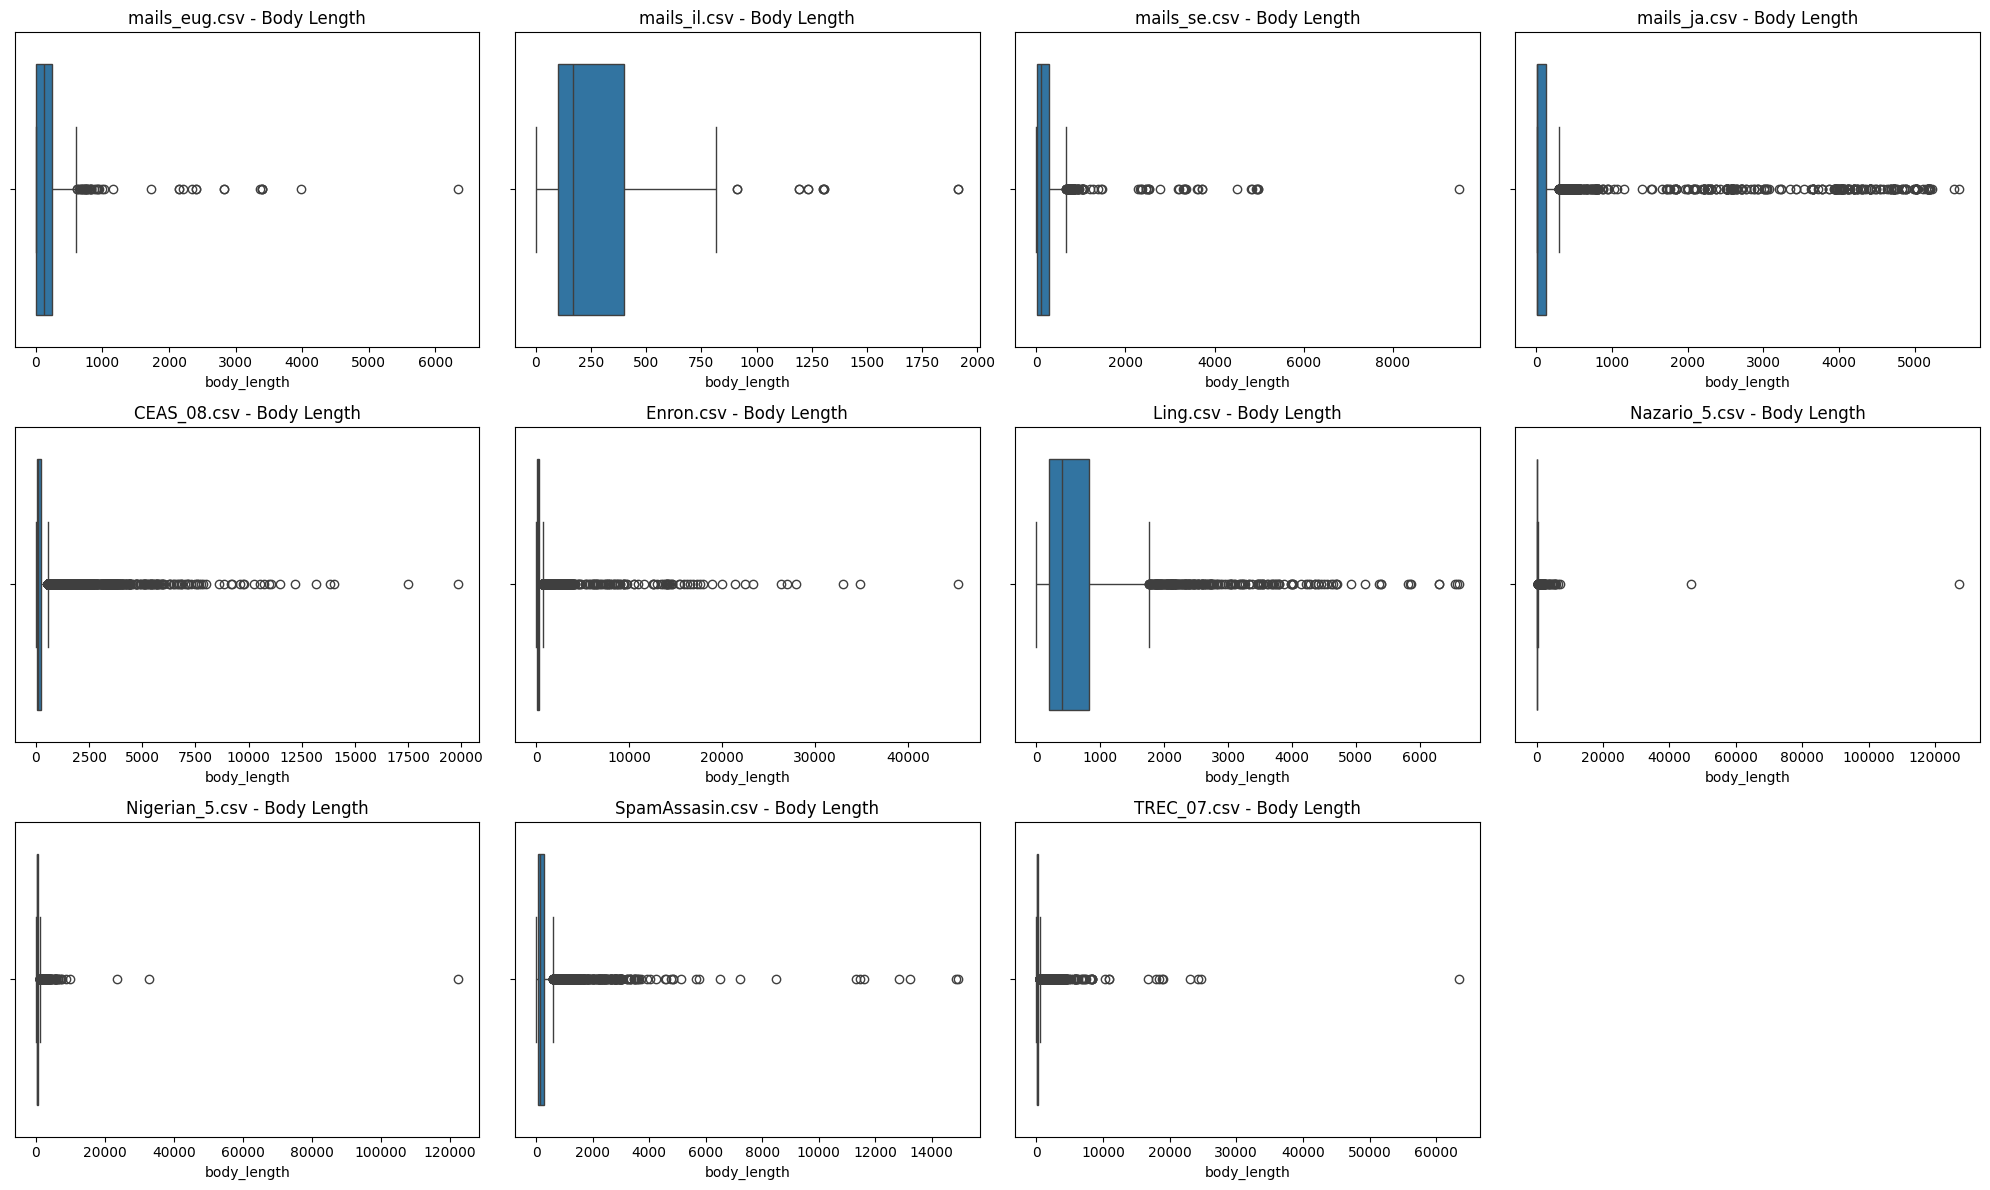

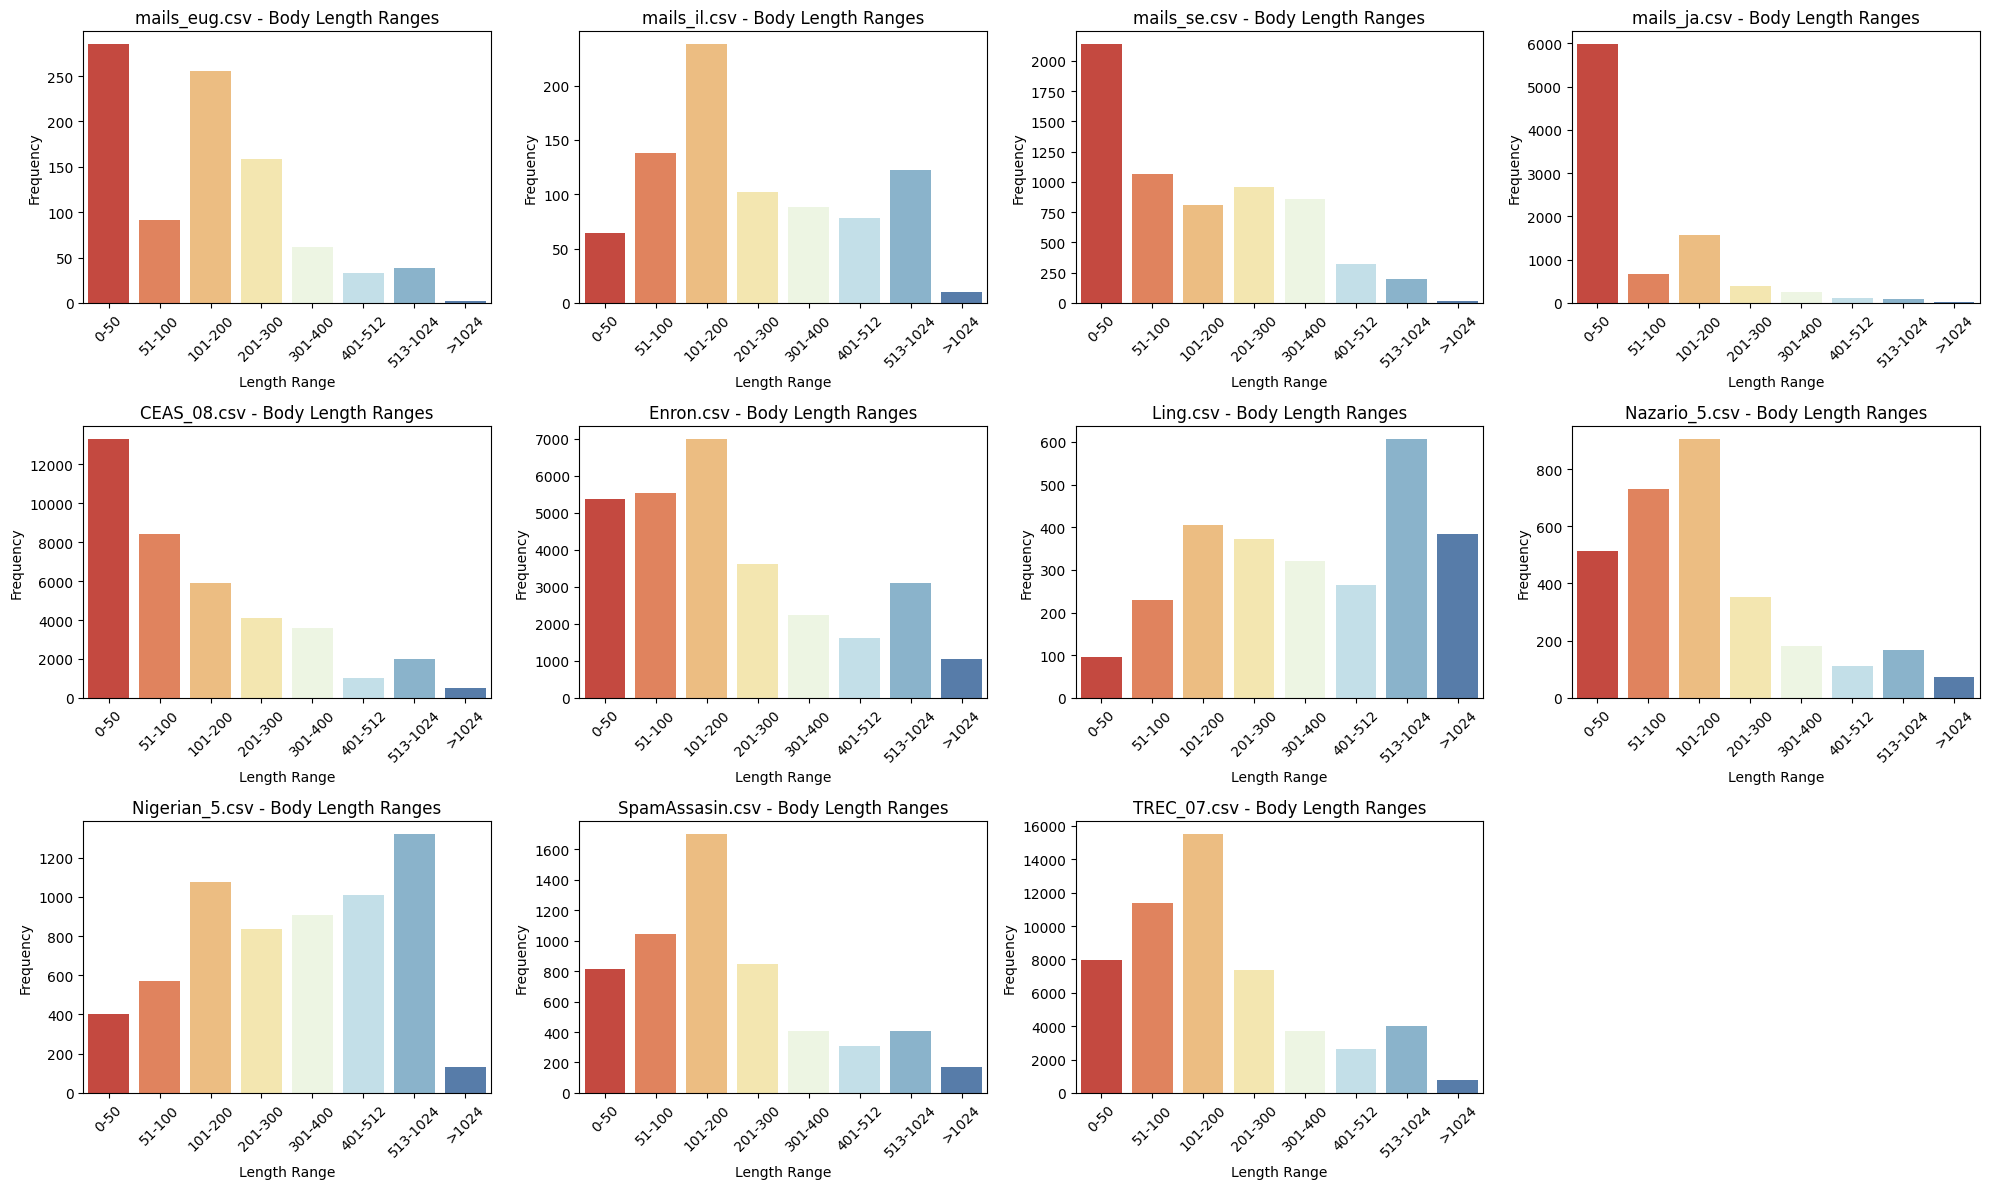

In [48]:
show_text_length_boxplots_multi(dfs, dataset_names)
show_text_length_bins_multi(dfs, dataset_names)

### Explore individual

In [41]:
file_path = dpr.path.data.raw.data_mail.curated.CEAS_08_csv

Dataset loaded: C:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert\data\raw\data_mail\curated\CEAS_08.csv

Dataset Information:
---------------------
Dataset Name   : CEAS_08.csv
Shape          : 39154 rows, 7 columns
Columns        : sender, receiver, date, subject, body, label, urls

Class Distribution:
--------------------
label
1    21842
0    17312
Name: count, dtype: int64


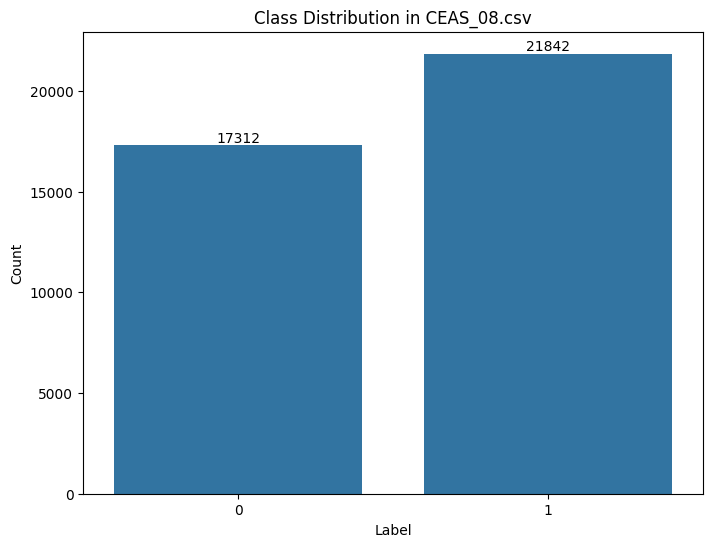


Missing Values:
----------------


,Missing Values
sender,0
receiver,462
date,0
subject,28
body,0
label,0
urls,0


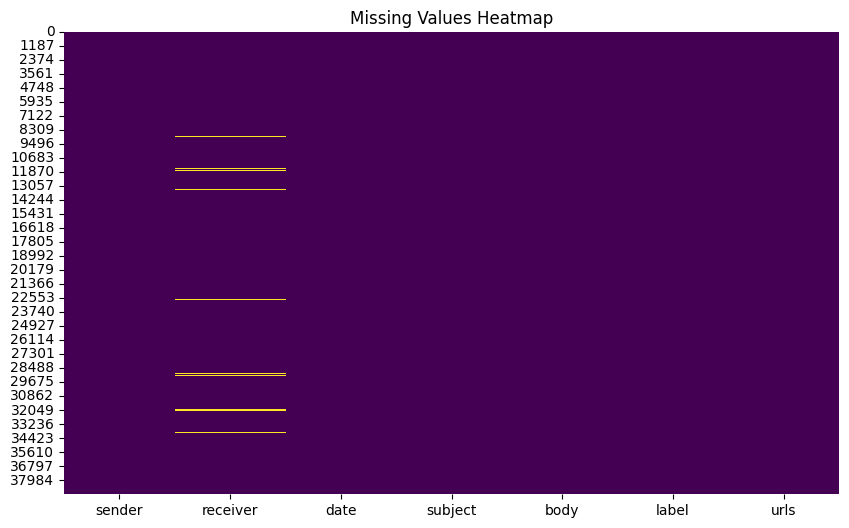


Text Lengths (Subject & Body):
-------------------------------
Max subject length: 52
Min subject length: 1
Avg subject length: 6.05
Max body length: 19863
Min body length: 1
Avg body length: 202.03


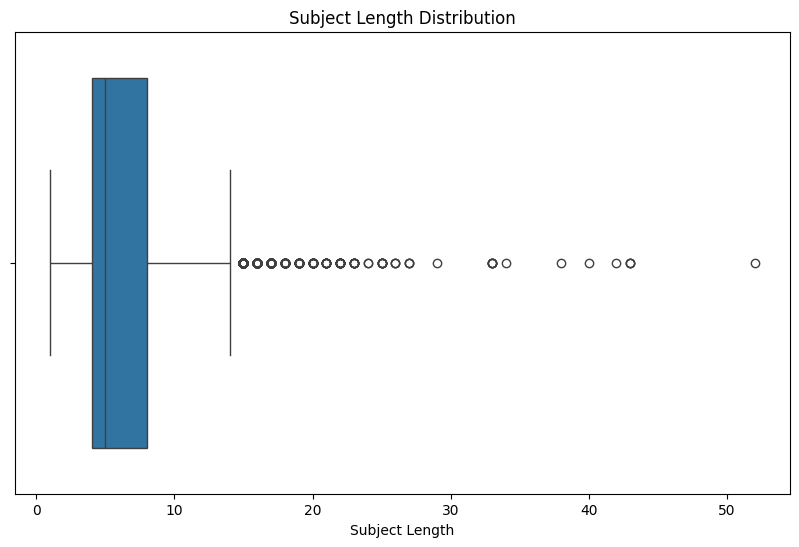

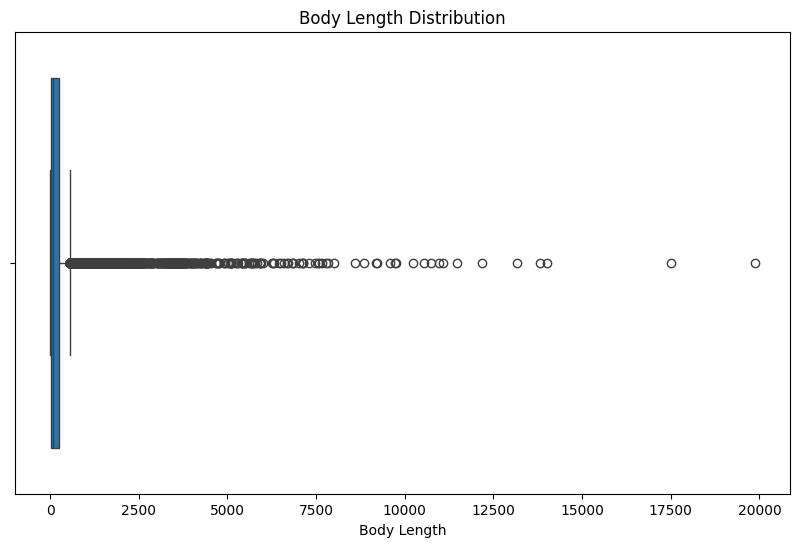

Row count ignoring NaNs: 39126/39154 (99.93%)

Text Lengths (Subject & Body):
-------------------------------
Max subject length: 52
Min subject length: 1
Avg subject length: 6.05
Max body length: 19863
Min body length: 1
Avg body length: 202.10


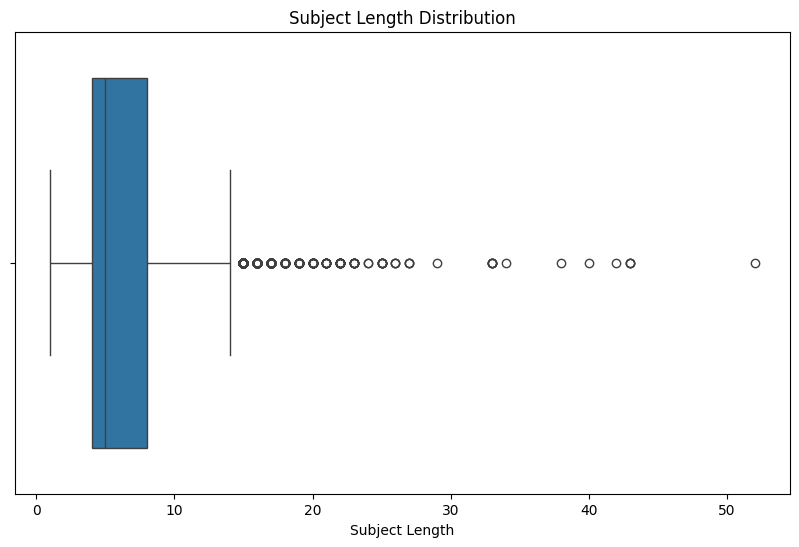

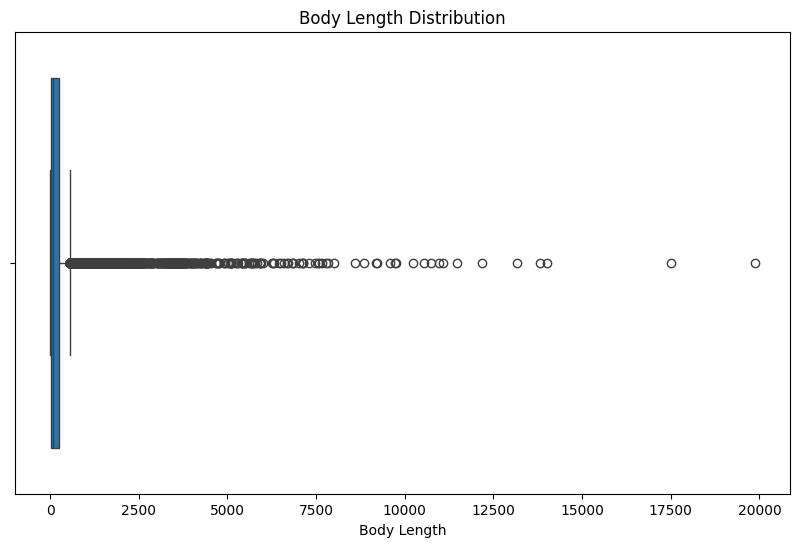

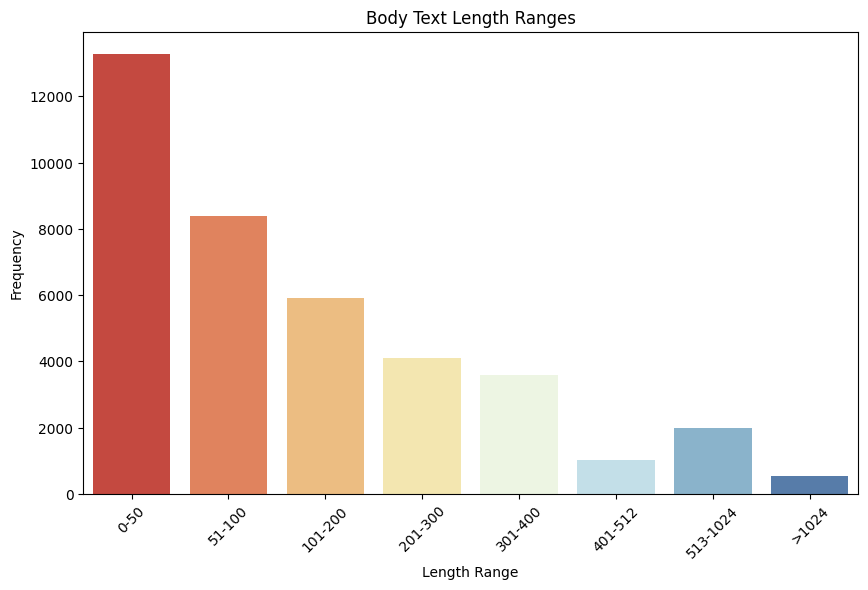


Most Common Sender and Receiver:
---------------------------------
Most common sender: qydlqcws-iacfym@issues.apache.org
Most common receiver: user6@gvc.ceas-challenge.cc


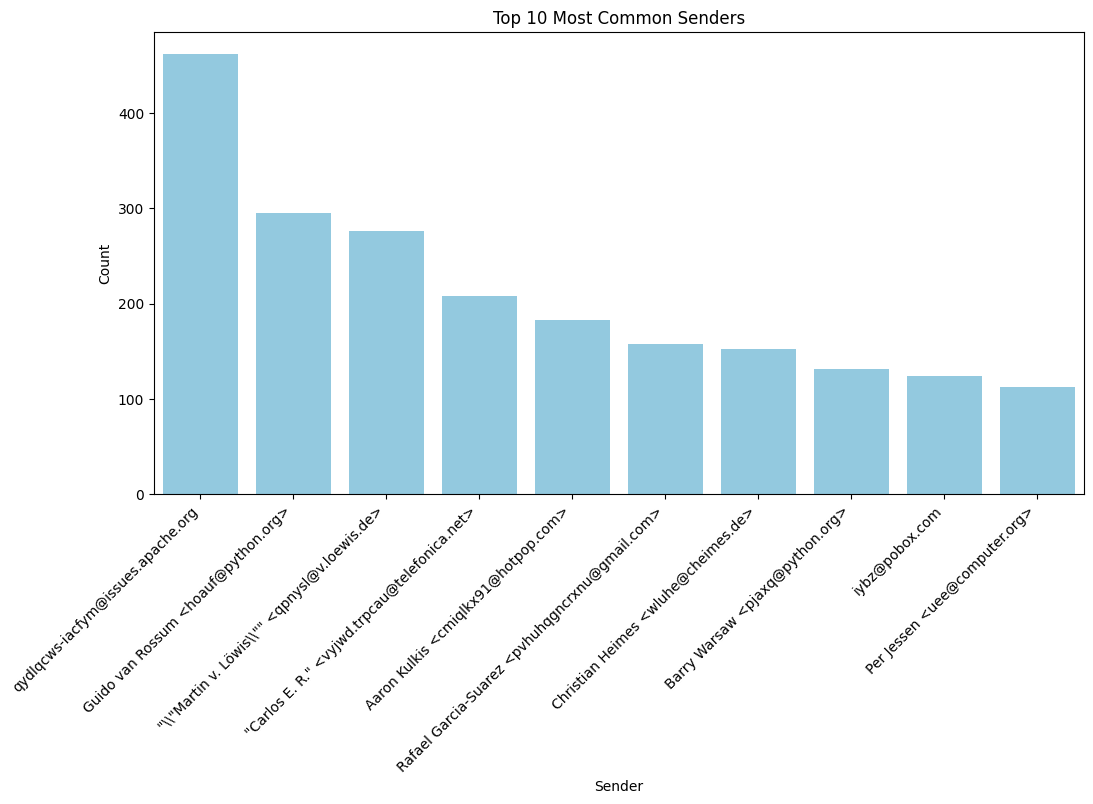

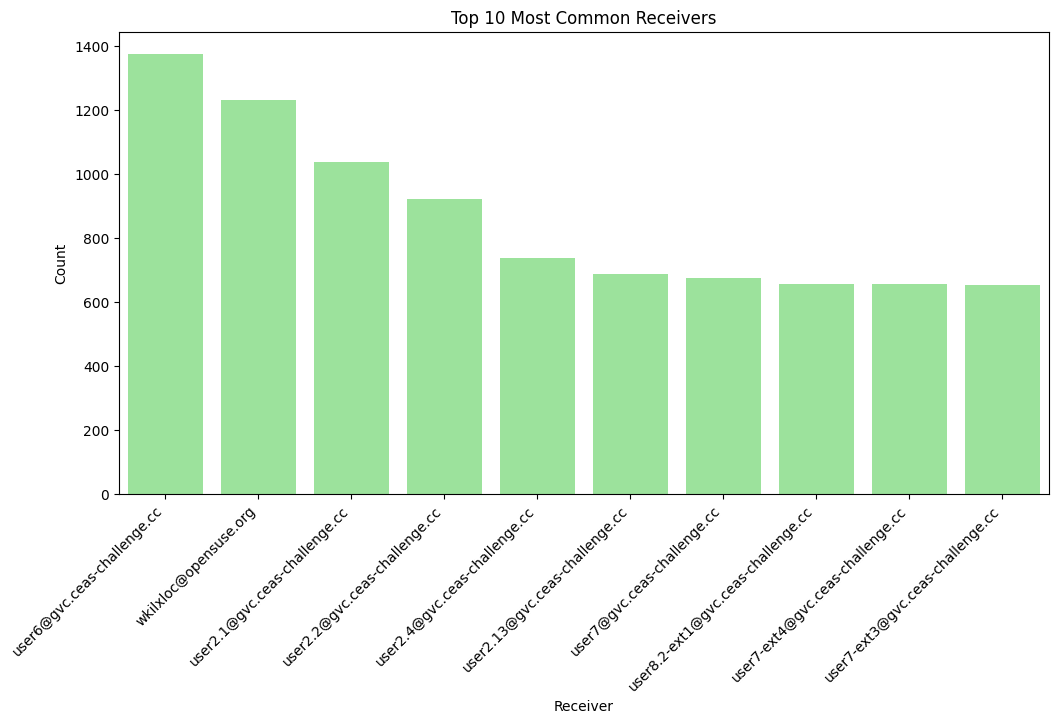


 Mails with URL
---------------------------------


,Label,Count
0,Mails with URLs,26222
1,Mails without URLs,12932


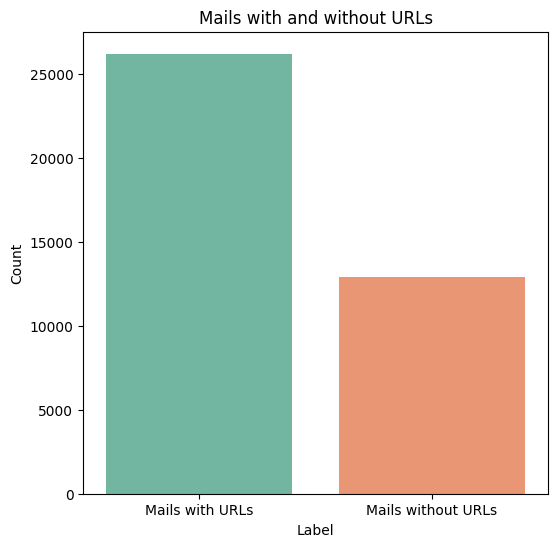

In [42]:
df = read_dataset(file_path)

if df is not None:
    show_dataset_info(df, file_path)
    show_nans(df)
    show_text_length_boxplots(df, ignore_nans=False)
    show_text_length_boxplots(df, ignore_nans=True)
    show_text_length_bins(df)
    show_most_common_sender_recipient(df)
    count_mails_with_urls(df)


Language Distribution (Subject and Body):
-------------------------------------------


,Body Language,Subject Language
af,0.0,344.0
ca,0.0,337.0
cy,10.0,0.0
da,6.0,435.0
de,5.0,1550.0
en,39063.0,32069.0
fr,5.0,967.0
it,4.0,312.0
nl,12.0,729.0
no,6.0,0.0


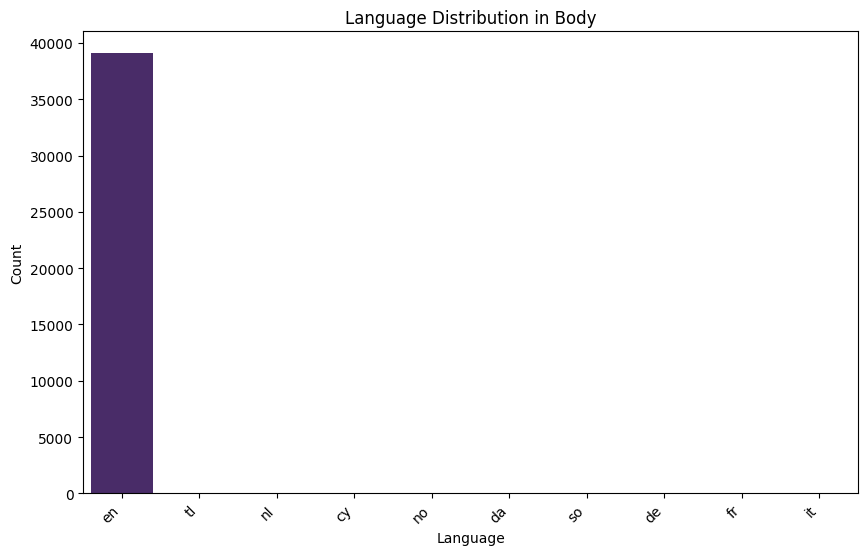

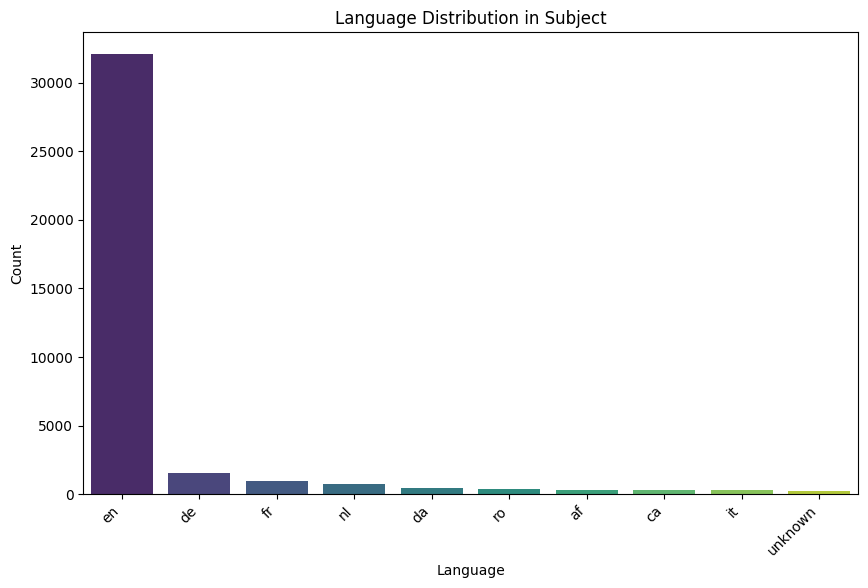


Wordclouds:
------------------------------------------
Wordcloud for Body (Label 0):
Total words in body: 6079007


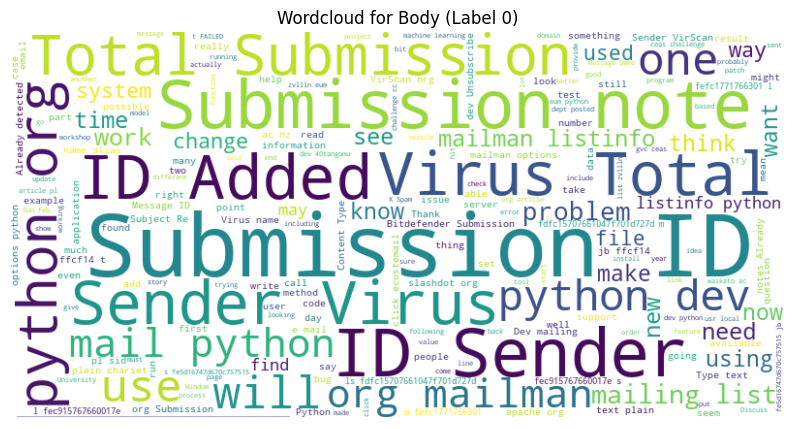

Wordcloud for Subject (Label 0):
Total words in subject: 122583


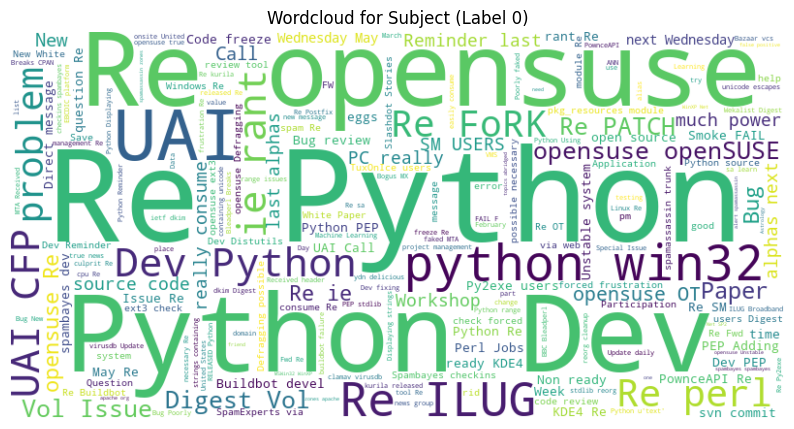


Wordclouds:
------------------------------------------
Wordcloud for Body (Label 1):
Total words in body: 1831470


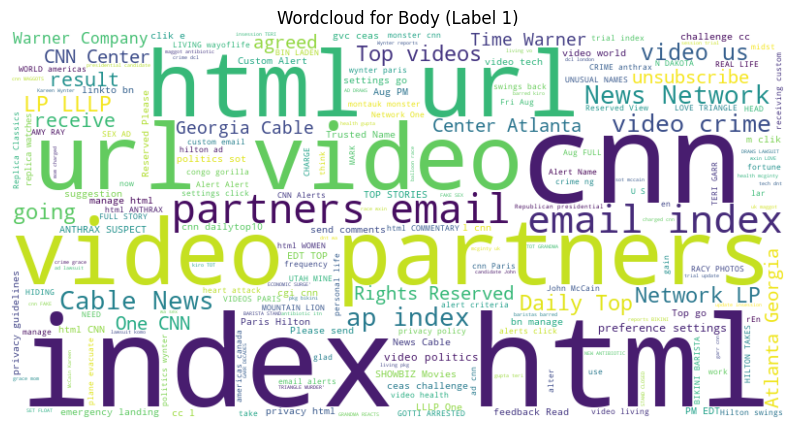

Wordcloud for Subject (Label 1):
Total words in subject: 114213


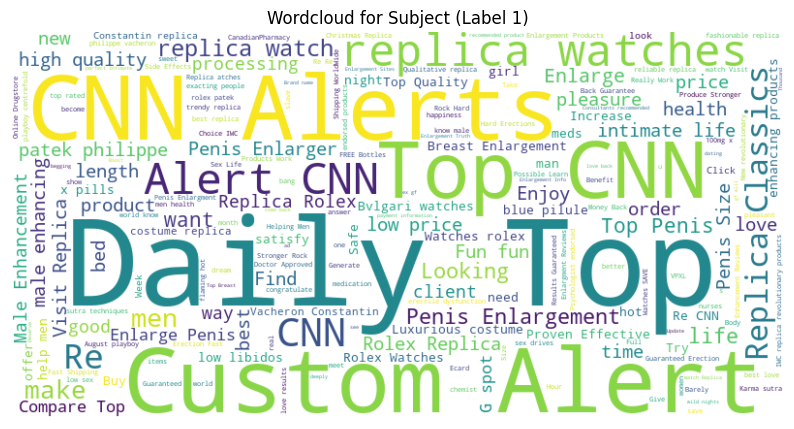

In [43]:
if df is not None:
    analyze_language_distribution(df)
    generate_wordclouds(df, label=0)  
    generate_wordclouds(df, label=1)  